Before starting the DataLab, preprocess the tweets like you did before.

In [1]:
import nltk
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd

In [2]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\neilr\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

In [3]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [4]:
print('Number of positive tweets: ', len(all_positive_tweets))
print('Number of negative tweets: ', len(all_negative_tweets))

Number of positive tweets:  5000
Number of negative tweets:  5000


In [5]:
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.corpus import stopwords          # module for stop words that come with NLTK
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

In [6]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_english = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neilr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def tweet_processor(tweet):
    """
    Input:
        tweet: a string containing a tweet
    Output:
        processed_tweet: a list of token
        
    Processing steps:
    - Removes hyperlinks
    - Removes # sign
    - Tokenizes
    - Removes stopwords and punctuation
    - Stem tokens
        
    """
    # YOUR CODE HERE #
    # Remove URLs using regular expression
    processed_tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)
    
    # Remove hashtags
    processed_tweet = re.sub(r'#([^\s]+)', r'\1', processed_tweet)
    
    # Tokenize the tweet using TweetTokenizer
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
    processed_tweet = tokenizer.tokenize(processed_tweet)
    
    # Remove stopwords
    stopwords_english = set(stopwords.words('english'))
    processed_tweet = [word for word in processed_tweet if word not in stopwords_english]
    
    # Remove punctuation
    processed_tweet = [word for word in processed_tweet if word not in string.punctuation]
    
    # Stem the tokens
    stemmer = PorterStemmer()
    processed_tweet = [stemmer.stem(word) for word in processed_tweet]

    return processed_tweet

In [10]:
tweet = all_positive_tweets[2277]
tweet_processed = tweet_processor(tweet)

print(tweet)
print(tweet_processed)

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


In [11]:
# 80% training 20% testing
positive_tweets_tr = all_positive_tweets[:4000]
positive_tweets_te = all_positive_tweets[4000:]

negative_tweets_tr = all_negative_tweets[:4000]
negative_tweets_te = all_negative_tweets[4000:]

In [12]:
def tweet_processor_list(tweet_list):
    # YOUR CODE HERE #
    processed_tweet_list = []
    for tweet in tweet_list:
        processed_tweet = tweet_processor(tweet)
        processed_tweet_list.append(processed_tweet)
    return processed_tweet_list

In [13]:
positive_tweets_tr = tweet_processor_list(positive_tweets_tr)
positive_tweets_te = tweet_processor_list(positive_tweets_te)

negative_tweets_tr = tweet_processor_list(negative_tweets_tr)
negative_tweets_te = tweet_processor_list(negative_tweets_te)

You already did the steps until here in the previous DataLab. Let's do a quick sanity check:

In [14]:
assert len(positive_tweets_tr) == 4000
assert len(negative_tweets_tr) == 4000

assert len(positive_tweets_te) == 1000
assert len(negative_tweets_te) == 1000

assert type(positive_tweets_tr) is list
assert type(positive_tweets_tr[0]) is list
assert type(positive_tweets_tr[0][0]) is str

# Introduction

In this DataLab you will train a neural network with an embedding layer for classifying tweets as positive and negative.

Until now, we based our models (Logistic Regression and Naive Bayes) on counting the words. For the first time, we will try to capture meaning as well by using embeddings.

To achieve this, we need to represent words as numbers because neural networks work with numbers.

## 1. Converting words to numbers

Before using the embedding layer, we need to convert tokens to numbers. The best way to explain how to do it is to actually show it. So let's use an example corpus with only 3 documents.

In [15]:
training_documents = ['This is a tasty apple.',
                      'Hello John!',
                      'I liked the movie.',
                      'I have a car.']

Let's use `Tokenizer` from Keras to convert these documents to numbers:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_documents)

What we just did was to simply tokenize all the documents, find the unique tokens (or words) and assign a number (index) to them. You can view the results by using the `word_index` attribute on the `tokenizer` object, which in fact is our vocabulary:

In [17]:
tokenizer.word_index

{'a': 1,
 'i': 2,
 'this': 3,
 'is': 4,
 'tasty': 5,
 'apple': 6,
 'hello': 7,
 'john': 8,
 'liked': 9,
 'the': 10,
 'movie': 11,
 'have': 12,
 'car': 13}

Now I can use the `tokenizer` object again to convert documents to numbers.

In [18]:
tokenizer.texts_to_sequences(training_documents)

[[3, 4, 1, 5, 6], [7, 8], [2, 9, 10, 11], [2, 12, 1, 13]]

`'Hello John!'` becomes `[7, 8]`.

But what happens if you would like to convert a document with an unknown word (out of vocabulary)? For example `'Hello Mary!'`

In [19]:
tokenizer.texts_to_sequences(['Hello Mary!'])

[[7]]

Unknown word is ignored. This is not ideal. It is better to have a special token that indicates unknown words. Let's repeat the steps above but this time with `oov_token="<OOV>"`

In [20]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(training_documents)

In [21]:
tokenizer.word_index

{'<OOV>': 1,
 'a': 2,
 'i': 3,
 'this': 4,
 'is': 5,
 'tasty': 6,
 'apple': 7,
 'hello': 8,
 'john': 9,
 'liked': 10,
 'the': 11,
 'movie': 12,
 'have': 13,
 'car': 14}

This time we have a new token for out of vocabulary words `<OOV>` with `1` as its index. Which means whenever we have an unknown word, it will be indexed as `1`.

In [22]:
tokenizer.texts_to_sequences(['Hello Mary!'])

[[8, 1]]

**Task 1.1**

Write a document with a few words and convert it to numbers using `tokenizer.texts_to_sequences()`.

In [23]:
# YOUR CODE HERE #
document = ['I love playing football with my friends!']

# Convert it to numbers
document_numbers = tokenizer.texts_to_sequences(document)
document_numbers

[[3, 1, 1, 1, 1, 1, 1]]

Let's take a look at our corpus turned into sequences again.

In [24]:
training_sequences = tokenizer.texts_to_sequences(training_documents)
training_sequences

[[4, 5, 2, 6, 7], [8, 9], [3, 10, 11, 12], [3, 13, 2, 14]]

Notice that naturally, the length of the sentences are different. But typically machine learning models expect a fixed input size, in other words a fixed number of features. Handling this is as easy as padding the short sentences with zeros. This can be done using `pad_sequences` from Keras.

https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
pad_sequences(training_sequences)

array([[ 4,  5,  2,  6,  7],
       [ 0,  0,  0,  8,  9],
       [ 0,  3, 10, 11, 12],
       [ 0,  3, 13,  2, 14]])

Zeros are added to the short sentences and now all sequences are 5 numbers long. Now let's dig deeper to understand the default arguments and how to change them.

For example by default zeros are added to the left. We can use `padding='post'` to add zeros to the right.

In [26]:
pad_sequences(training_sequences,
              padding='post')

array([[ 4,  5,  2,  6,  7],
       [ 8,  9,  0,  0,  0],
       [ 3, 10, 11, 12,  0],
       [ 3, 13,  2, 14,  0]])

Note that the length of the sequences are equal to the longest sentence. We can make it shorter or longer.

In [27]:
pad_sequences(training_sequences,
              padding='post',
              maxlen=3)

array([[ 2,  6,  7],
       [ 8,  9,  0],
       [10, 11, 12],
       [13,  2, 14]])

In [28]:
pad_sequences(training_sequences,
              padding='post',
              maxlen=6)

array([[ 4,  5,  2,  6,  7,  0],
       [ 8,  9,  0,  0,  0,  0],
       [ 3, 10, 11, 12,  0,  0],
       [ 3, 13,  2, 14,  0,  0]])

and as you might have guessed we can decide if we want to truncate from left or right of the sentence.

In [29]:
pad_sequences(training_sequences,
              padding='post',
              maxlen=3,
              truncating='post')

array([[ 4,  5,  2],
       [ 8,  9,  0],
       [ 3, 10, 11],
       [ 3, 13,  2]])

**Summary**

We started with a list of strings, in other words a corpus with documents.

```
training_documents = ['This is a tasty apple.',
                      'Hello John!',
                      'I liked the movie.',
                      'I have a car.']
```

Then, fit a `tokenizer` to it, which assigned a number to every unique word.

```
{'<OOV>': 1,
 'a': 2,
 'i': 3,
 'this': 4,
 'is': 5,
 'tasty': 6,
 'apple': 7,
 'hello': 8,
 'john': 9,
 'liked': 10,
 'the': 11,
 'movie': 12,
 'have': 13,
 'car': 14}
```

Finally we converted strings into numbers. We used padding to obtain a fixed length for sequences.

```
array([[ 4,  5,  2,  6,  7],
       [ 8,  9,  0,  0,  0],
       [ 3, 10, 11, 12,  0],
       [ 3, 13,  2, 14,  0]], dtype=int32)
```

## 2. Converting tweets to numbers

Now it is time to apply what you have learned to tweets. But let's first create `training_tweets` and `test_tweets` by combining positive and negative tweets.



In [30]:
training_tweets = positive_tweets_tr + negative_tweets_tr
test_tweets = positive_tweets_te + negative_tweets_te

While we are creating our dataset, we can also create our labels. We know that first half of `training_tweets` and `test_tweets` are positive (label = 1) and second half is negative (label = 0). Therefore creating the labels is as easy as:

In [31]:
y_train = np.append(np.ones(len(positive_tweets_tr)),
                    np.zeros(len(negative_tweets_tr)))

y_test = np.append(np.ones(len(positive_tweets_te)),
                   np.zeros(len(negative_tweets_te)))

print(y_train.shape)
print(y_test.shape)

(8000,)
(2000,)


Remember that we already preprocessed and tokenized our tweets:

In [32]:
training_tweets[0]

['followfriday',
 '@france_int',
 '@pkuchly57',
 '@milipol_pari',
 'top',
 'engag',
 'member',
 'commun',
 'week',
 ':)']

But Keras `Tokenizer()` expects a list of strings. So let's combine tokens into strings:

In [33]:
training_tweets_str = []
for tw in training_tweets:
    training_tweets_str.append(' '.join(tw))
    
test_tweets_str = []
for tw in test_tweets:
    test_tweets_str.append(' '.join(tw))

In [34]:
training_tweets_str[0]

'followfriday @france_int @pkuchly57 @milipol_pari top engag member commun week :)'

**Task 2.1**

Use tokenizer on `training_tweets_str`. Notice that tokenizer processes text with the `filters` parameter. Set it to `filters=''` to prevent processing because we already processed our tweets.

In [35]:
# YOUR CODE HERE #
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(training_tweets_str)

**Task 2.2**

Calculate the size of the vocabulary.

In [36]:
vocab_size = len(tokenizer.word_index)
print(vocab_size)

14885


**Task 2.3**

Find the numbers that represent the words `'boy'`, `'girl'`, `'man'` and `'woman'`.

In [37]:
boy_index = tokenizer.word_index.get('boy', 0)
girl_index = tokenizer.word_index.get('girl', 0)
man_index = tokenizer.word_index.get('man', 0)
woman_index = tokenizer.word_index.get('woman', 0)

print(f"The index of 'boy' is {boy_index}")
print(f"The index of 'girl' is {girl_index}")
print(f"The index of 'man' is {man_index}")
print(f"The index of 'woman' is {woman_index}")

The index of 'boy' is 354
The index of 'girl' is 154
The index of 'man' is 203
The index of 'woman' is 897


**Task 2.4**

Convert training and test tweets to sequences and use padding.

Example tweet:

`'followfriday top engag member commun week :)'`

Corresponding sequence:

`[347, 221, 937, 400, 286, 52, 3]`

Padded sequence:

`array([347, 221, 937, 400, 286,  52,   3,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)`


For padding arguments use `padding='post'` and `maxlen=30`.

In [38]:
training_sequences = tokenizer.texts_to_sequences(training_tweets_str)
training_padded = pad_sequences(training_sequences, padding='post', maxlen=30)

test_sequences = tokenizer.texts_to_sequences(test_tweets_str)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=30)

In [39]:
assert training_padded.shape == (8000, 30)
assert test_padded.shape == (2000, 30)

## 3. Build a neural network with an embedding layer

You just converted tweets to numbers, now we are ready to train a neural network on this dataset. Let's first define `X_train`, `y_train`, `X_test`, `y_test`. We already created the labels and padded sequences will be our `X_train` and `X_test`.

In [43]:
X_train = training_padded
X_test = test_padded

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 30), (8000,), (2000, 30), (2000,))

**Task 3.1**

Build a `Sequential` model from Keras. First layer should be an `Embedding` layer. In the `Embedding` layer define the following parameters:

>input_dim: Integer. Size of the vocabulary, i.e. maximum integer index + 1.

>output_dim: Integer. Dimension of the dense embedding.

>input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).

Note that `input_dim` is `vocab_size + 1` because we are padding with zeros. For `output_dim` please use `2` because we would like to plot the embeddings. Finally for `input_length` use `30` because we used `maxlen=30` during padding.

After the `Embedding` layer flatten its output and connect `Dense` layers. As a last layer, add a `Dense` layer suitable for binary classification.

In [40]:
from keras import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=vocab_size + 1, output_dim=2, input_length=30))

# Flatten the output of the Embedding layer
model.add(Flatten())

# Add Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 2)             29772     
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 64)                3904      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 33741 (131.80 KB)
Trainable params: 33741 (131.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Task 3.2**

Compile the model by selecting a proper loss, optimizer and metric.

In [41]:
# YOUR CODE HERE #
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

**Task 3.3**

Train the model with `X_train` and `y_train`. Use `X_test` and `y_test` as validation data.

In [45]:
# YOUR CODE HERE #
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


250/250 [==============================] - 1s 2ms/step - loss: 0.4451 - accuracy: 0.8508 - val_loss: 0.0793 - val_accuracy: 0.9950
Epoch 2/10
250/250 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9955 - val_loss: 0.0181 - val_accuracy: 0.9975
Epoch 3/10
250/250 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.9990 - val_loss: 0.0119 - val_accuracy: 0.9975
Epoch 4/10
250/250 [==============================] - 0s 1ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.0090 - val_accuracy: 0.9975
Epoch 5/10
250/250 [==============================] - 0s 1ms/step - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0077 - val_accuracy: 0.9980
Epoch 6/10
250/250 [==============================] - 0s 1ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9975
Epoch 7/10
250/250 [==============================] - 0s 1ms/step - loss: 6.6159e-04 - accuracy: 1.0000 - val_loss: 0.0069 - val_accuracy: 0.9980


You just developed a neural network for sentiment analysis congrats!

**Task 3.4**

Predict the class of a test tweet.

Example tweet:
`"back thnx god i'm happi :)"`

Model prediction:
`array([[0.99999976]], dtype=float32)`

In [46]:
# YOUR CODE HERE #
example_tweet = "back thnx god i'm happy :)"

# Tokenize and pad the example tweet
example_sequence = tokenizer.texts_to_sequences([example_tweet])
example_padded = pad_sequences(example_sequence, padding='post', maxlen=30)

# Predict the class
prediction = model.predict(example_padded)
prediction

1/1 [==============================] - 0s 63ms/step


array([[0.9999123]], dtype=float32)

## 4. Semantic properties of embeddings

Take a look at Figures 6.15 and 6.16 (Section 6.10, page 126, Speech and Language Processing). They show one of the ways embeddings capture meaning in language. Let's try if embeddings from our model learned any semantic properties.

In order to achieve this we need to access the output of our trained embedding layer, which is the first layer. We can access each layer as follows:

In [47]:
model.layers

and input/output of a layer as follows:

In [48]:
model.layers[0].input

<KerasTensor: shape=(None, 30) dtype=float32 (created by layer 'embedding_input')>

In [49]:
model.layers[0].output

<KerasTensor: shape=(None, 30, 2) dtype=float32 (created by layer 'embedding')>

We can create a new model only from the trained Embedding layer.

In [50]:
from tensorflow.keras.models import Model
embedding_model = Model(inputs=model.layers[0].input,
                        outputs=model.layers[0].output)

`embedding_model` accepts sequences as input and returns the output of the embedding layer.

**Task 4.1**

We can use this model, just like any model. Use the `embedding_model` on the test tweet you used for Task 3.4 and get the embeddings. You should obtain two numbers for each word in the tweet. These two numbers are called word embeddings.

Example tweet:

`"back thnx god i'm happi :)"`

Expected output:

```
array([[[ 2.03354090e-01, -1.61128387e-01],
        [ 3.02020200e-02, -4.17610519e-02],
        [-6.28291816e-03, -3.17817833e-03],
        [ 1.16536245e-01, -1.00184120e-01],
        [-2.93731004e-01,  2.99061388e-01],
        [-1.42090285e+00,  1.37957323e+00],
        [-7.92113831e-04,  2.80260388e-02],
        [-7.92113831e-04,  2.80260388e-02],
        [-7.92113831e-04,  2.80260388e-02],
        ...
        [-7.92113831e-04,  2.80260388e-02]]], dtype=float32)
```

where `'back'` is `[ 2.03354090e-01, -1.61128387e-01]`.

In [51]:
# YOUR CODE HERE #
# Example tweet
example_tweet = "back thnx god i'm happy :)"

# Tokenize the example tweet
example_sequence = tokenizer.texts_to_sequences([example_tweet])

# Pad the tokenized sequence
example_padded = pad_sequences(example_sequence, padding='post', maxlen=30)

# Get the embeddings using the embedding_model
embeddings = embedding_model.predict(example_padded)
embeddings

1/1 [==============================] - 0s 32ms/step


array([[[-0.02959852, -0.05010784],
        [-0.01541641,  0.0008052 ],
        [ 0.02914905, -0.0649142 ],
        [-0.468154  ,  0.39904687],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.11808489],
        [-0.05754199, -0.118

Using the idea above, let's create a function that can give us a vector (word embedding) for any given word.

**Task 4.2**

Write a function that:
- Accepts a word as a string
```
'man'
```
- Converts it into a sequence using the `tokenizer` you fitted previously
```
[[199]]
```
- Pads it
```
array([[199,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int32)
```
- Uses the `embedding_model` to get the embeddings
```
array([[[ 0.13211662,  0.11832968],
        [-0.03486646, -0.00182698],
        [-0.03486646, -0.00182698],
        [-0.03486646, -0.00182698],
        [-0.03486646, -0.00182698],
        ...
        [-0.03486646, -0.00182698]]], dtype=float32)
```
- And finally returns the embedding (vector) that corresponds to the word e.g. 
```
array([0.13211662, 0.11832968], dtype=float32)
```

In [52]:
def word_to_vector(word):
    """
    Input:
        word: a string containing the word
    Output:
        vector: a numpy array containing the vector obtained 
                from the trained embedding layer
    """
    # Tokenize the word
    word_sequence = tokenizer.texts_to_sequences([word])
    
    # Pad the tokenized sequence
    padded_sequence = pad_sequences(word_sequence, padding='post', maxlen=30)
    
    # Get the embeddings using the embedding_model
    embeddings = embedding_model.predict(padded_sequence)
    
    # Return the embedding (vector) corresponding to the word
    return embeddings[0][0]

In [53]:
vector = word_to_vector('man')
vector

1/1 [==============================] - 0s 15ms/step


array([ 0.02573082, -0.04593407], dtype=float32)

In [54]:
assert type(vector) == np.ndarray
assert vector.shape == (2,)

**Task 4.3**

Plot the embeddings of the following words `['boy', 'girl', 'man', 'woman']` and check if your model captures the male-female relation.

<img src=https://i.imgur.com/CUZuvxW.png width="400">

In [55]:
def word_plotter(words):
    # Get embeddings for each word
    vectors = [word_to_vector(word) for word in words]

    # Extract x and y coordinates from embeddings
    x = [vector[0] for vector in vectors]
    y = [vector[1] for vector in vectors]

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue')
    for i, word in enumerate(words):
        plt.annotate(word, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Word Embeddings')
    plt.grid(True)
    plt.show()

1/1 [==============================] - 0s 15ms/step


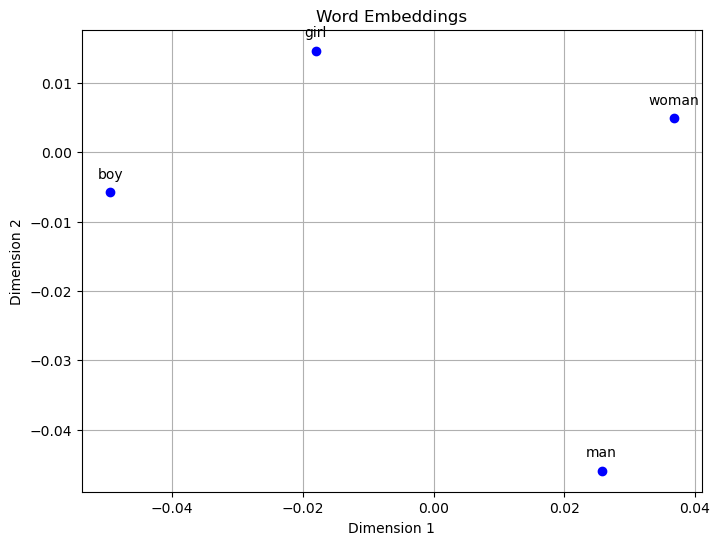

In [56]:
word_plotter(['boy', 'girl', 'man', 'woman'])